In [142]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
import seaborn as sns
from pathlib import Path
import requests
import json


In [143]:
alpha_api = 'GQ3V6KMM3ISFS1NB'

# global variables 
indexes = 'SPY QQQ IWM DIA'
sectors = 'IYC IYH IYK IYR IYZ XLB XLE XLF XLI XLK XLU'
index_plus_sectors = indexes + ' ' + sectors

optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

stocks_by_sector = pd.read_csv(Path('./Resources/stocks_by_sector.csv'))
# dates
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()

date_list = [one_year, three_years_ago, five_years_ago, ten_years_ago, thirty_years_ago]
sqrt_252 = np.sqrt(252)

In [144]:
# method for getting close prices on a list of stocks
# important - don't put unnecessary spaces in the tickers, especially if it's a single ticker
def get_close(start, end, tickers = 'spy', interval = '1d'):
    
    if len(tickers) < 5:
        df = yf.Ticker(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']
        data.dropna(inplace= True)
        data = data.rename(tickers)
    else:
        df = yf.Tickers(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']
        data.dropna(inplace= True)    
        
    data.index = data.index.date
    return data

# method for getting cumulative return on a stock from a series of close prices
def get_cumprod(series):
    series = series.pct_change()
    series = (series + 1).cumprod()
    series.dropna(inplace= True)
    return series

# get correlation matrix from multiple series
def get_corr(stocks = []):
    all_stocks = pd.concat(stocks, axis=1).dropna()
    all_stocks = all_stocks.corr()
    return all_stocks

# method for getting er dates
def get_er_range(stock, api_key, delta = 10):
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyEarnings'])
    df= pd.Series(df['reportedDate'])
    # convert the series to a datetime format
    dates = pd.to_datetime(df)
    # create an empty list to hold the new date ranges
    date_ranges = []
    # loop over each date in the series
    for date in dates:
        # create a date range for 10 days before and after the current date
        date_range = pd.date_range(date - pd.Timedelta(days=delta), date + pd.Timedelta(days=delta))
        # convert the date range to a Series object
        date_range_series = pd.Series(date_range)
        # add the date range to the list of date ranges
        date_ranges.append(date_range_series)
    # concatenate the list of date ranges into a single Series object
    new_dates = pd.concat(date_ranges)
    # remove any duplicates and sort the new series
    new_dates = pd.Series(sorted(set(new_dates)))
    # print the new series
    return new_dates


def get_income_statement(stock, api_key):
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyReports'])
    return df

def get_balance_sheet(stock, api_key):
    url = f"https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyReports'])
    return df

# returns a df that has cumulative return for a set period for holding a stock vs holding it during er window
def comp_er_window(ticker, start, end, api_key):

    pct = get_close(start = start, end = end, tickers = ticker).pct_change()
    _range = get_er_range(ticker, api_key)

    standard_final = (pct + 1).cumprod().iloc[-1]
    pct = pct.reset_index()


    er_window = pd.concat([_range, pct], axis = 1, join = 'inner').drop('index', axis = 1)
    er_window.set_index(er_window.columns[0], inplace= True)
    er_window.dropna(inplace= True)
    er_final = (er_window + 1).cumprod().iloc[-1].values.astype(float)

    out = pd.DataFrame({
        "Buy and hold": standard_final,
        "Buy During Earnings": er_final
    })
    return out

# get a series of total returns on a weighted portfolio
def portfolio_returns(tickers, weights, start, end):
    portfolio = get_cumprod(get_close(start=start, end = end, tickers = tickers))
    return portfolio.dot(weights)

In [145]:
optionable_stocks

'FCX GOLD NEM WPM X TMUS VZ ROKU SNAP SPOT T NFLX META DIS DISH ATVI AMZN DHI ETSY GM MGM NKE HD M SBUX TSLA WMT TGT MO KO PEP PG PM CAG BYND ADM APA CCJ CVX DVN MRO HAL MPC SLB OXY VLO MA MARA JPM PYPL MS GDXJ BX COF AXP C BAC AFL AMGN ABBV ABT BMY CAH CVS PFE JNJ MDT MRK MRNA WBA RTX LUV PLUG MMM GE CAT CSX DAL BA AAL AMT WELL ZM SQ AMD AAPL CRM MRVL NVDA ORCL QCOM MSFT MU HPQ INTC '

In [146]:
sectors = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = index_plus_sectors))
risk_free_rate = get_close(thirty_years_ago, yesterday, '^irx')
combined = pd.concat([sectors, risk_free_rate], join = 'inner', axis = 1)
combined

[*********************100%***********************]  15 of 15 completed


,DIA,IWM,IYC,IYH,IYK,IYR,IYZ,QQQ,SPY,XLB,XLE,XLF,XLI,XLK,XLU,^irx
2000-06-29,0.989324,0.984375,1.000000,1.014078,1.000000,1.000000,0.980652,0.974900,0.990554,0.981721,1.002037,0.999359,0.982599,0.980392,0.984022,5.670
2000-06-30,0.990510,0.993840,0.995811,1.005825,1.000000,1.000000,0.982179,0.994016,0.998068,0.957349,0.988798,0.974984,0.984230,1.000000,0.960881,5.700
2000-07-03,1.005635,1.007813,0.995811,1.025243,1.000000,1.005742,0.993381,1.013297,1.011807,0.984006,0.994908,0.992944,0.997281,1.006921,0.989531,5.870
2000-07-05,0.996441,0.996394,0.995811,1.039806,1.000000,1.015018,1.004073,0.974069,0.993560,0.988575,0.953666,1.003849,0.988581,0.974625,0.998347,5.810
2000-07-06,0.997331,1.008113,1.017801,1.033980,1.000000,1.018109,1.004073,1.000000,1.001288,0.962681,0.963340,1.011546,0.985862,0.989620,0.999449,5.840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,5.356315,4.549558,5.125289,5.814891,7.971186,6.073691,0.666379,3.992377,4.351169,6.599994,4.923330,2.649601,5.317286,3.666071,5.452010,4.865
2023-05-02,5.301392,4.456127,5.117283,5.780368,7.944310,5.969984,0.647213,3.957557,4.302265,6.536052,4.709247,2.589528,5.261754,3.631820,5.385734,5.040
2023-05-03,5.257957,4.472477,5.078855,5.784067,7.898236,5.941375,0.644559,3.931659,4.272734,6.463912,4.620337,2.559892,5.241657,3.601212,5.370743,5.095
2023-05-04,5.214208,4.422388,5.026818,5.738243,7.864832,5.990010,0.633355,3.917781,4.242471,6.422103,4.568864,2.527053,5.184539,3.583965,5.411771,5.055


In [147]:
port_return = portfolio_returns('tsla amzn nflx', [1/3,1/3,1/3], ten_years_ago, yesterday)
port_return.hvplot()

[*********************100%***********************]  3 of 3 completed


:Curve   [index]   (0)

In [148]:
sectors = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = index_plus_sectors))
sectors_10 = get_cumprod(get_close(ten_years_ago, yesterday, tickers = index_plus_sectors))
sectors_5 = get_cumprod(get_close(five_years_ago, yesterday, tickers = index_plus_sectors))
sectors_3 = get_cumprod(get_close(three_years_ago, yesterday, tickers = index_plus_sectors))
sectors_1 = get_cumprod(get_close(one_year, yesterday, tickers = index_plus_sectors))
sectors_6_months = get_cumprod(get_close(six_months, yesterday, tickers = index_plus_sectors))

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


# Market Statistics Report

## Index, Sector and Stock Returns Analysis

## Risk Analysis for Indexes, Sectors and Optionable Stocks

## Correlation Analysis for Indexes, Sectors and Optionable stocks

In [149]:
sectors.hvplot().opts(height = 400,
                     width = 1000)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [150]:
sectors_corr_30 = sectors.corr()
sectors_corr_10 = sectors_10.corr()
sectors_corr_5 = sectors_5.corr()
sectors_corr_3 = sectors_3.corr()
sectors_corr_1 = sectors_1.corr()
sectors_corr_6_months = sectors_6_months.corr()

<AxesSubplot:>

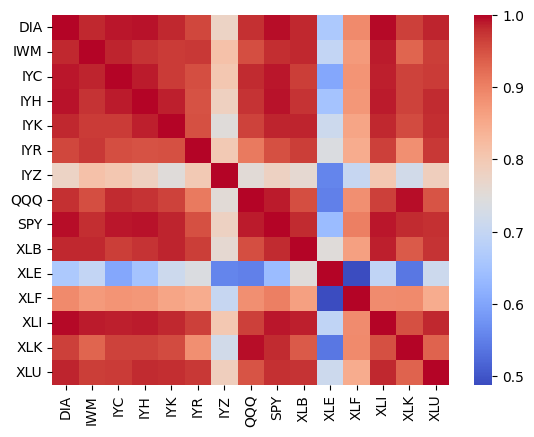

In [151]:
sns.heatmap(sectors_corr_30, cmap = 'coolwarm')

<AxesSubplot:>

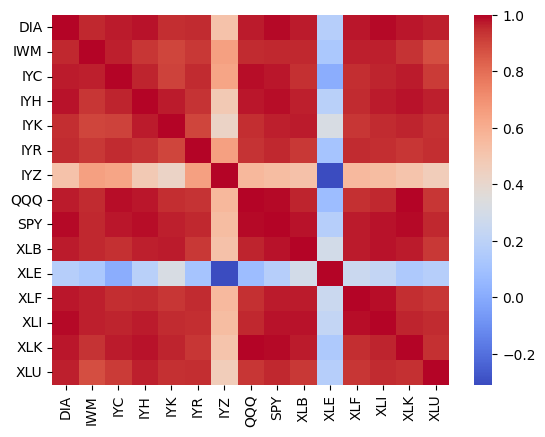

In [152]:
sns.heatmap(sectors_corr_10, cmap = 'coolwarm')

<AxesSubplot:>

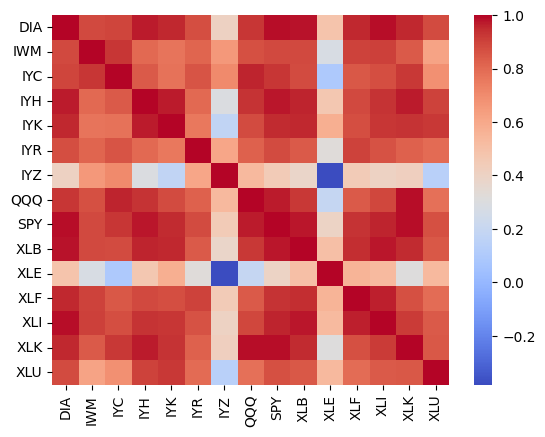

In [153]:
sns.heatmap(sectors_corr_5, cmap = 'coolwarm')

<AxesSubplot:>

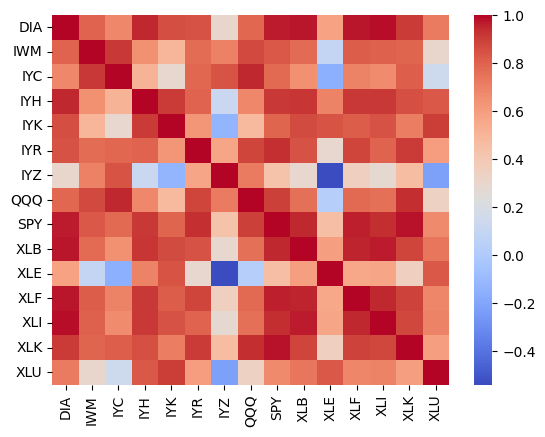

In [154]:
sns.heatmap(sectors_corr_3, cmap = 'coolwarm')

<AxesSubplot:>

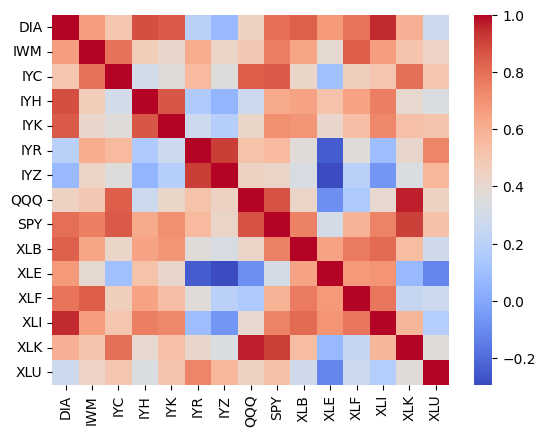

In [155]:
sns.heatmap(sectors_corr_1, cmap = 'coolwarm')

<AxesSubplot:>

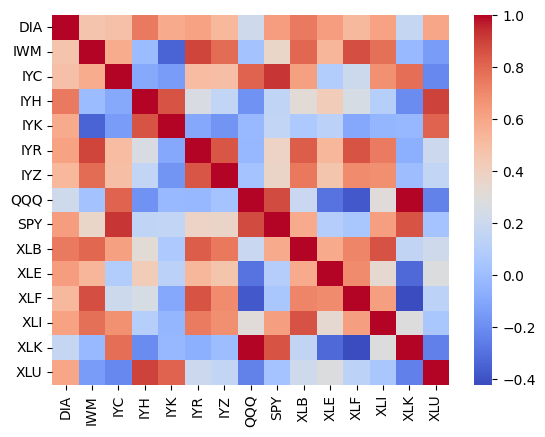

In [156]:
sns.heatmap(sectors_corr_6_months, cmap = 'coolwarm')

## Sharpe Ratio Analysis for Indexes, Sectors and Optionable Stocks

## Market Statistics Analysis Summary

### Key Learnings

## Stock Earnings and Fundamental Report

## Growth Stocks vs. Value Stocks Analysis

### Key Metrics Differentiating Groups

In [157]:
# separate the list of stocks by sectors ==
# plot them by sectors ==
# separate them by dividend yield and p/e ratio  ==
# Get returns for 1,3,5,10,30 years ==
# calculate sharpe ratios for basckets of growth vs value ==
# Find the optimal balance of growth and value for each time period

In [158]:
stocks_grouped = stocks_by_sector.groupby('Sector').count()
stocks_grouped.hvplot.bar(rot = 35,
                         width = 1000,
                         height = 400,
                         hover_color = 'orange')

:Bars   [Sector]   (Ticker)

In [159]:
# "DividendYield": "0",
#   "EPS": "3.397",
dividend_yield = []
pe_ratio = []
for stock in stocks_by_sector['Ticker']:
    try:
        ticker = yf.Ticker(stock)
        try:
            pe = ticker.info['trailingPE']
        except KeyError:
            pe = 0
        
        try:
            dyield = ticker.info['dividendYield']
        except KeyError:
            dyield = 0
        
        dividend_yield.append(dyield)
        pe_ratio.append(pe)
    
    except:
        dividend_yield.append(None)
        pe_ratio.append(None)
    
    
stocks_by_sector['DividendYield'] = dividend_yield
stocks_by_sector['PERatio'] = pe_ratio
print('done')

done


In [182]:
# pe_th <15
# dy_th >0.02
stocks_by_sector.hvplot.scatter(groupby = 'Sector',
                                x='DividendYield',
                               y= 'PERatio',
                                color = 'DividendYield',
                                cmap = 'kr',
                               hover_cols=['Ticker'])

:DynamicMap   [Sector]
   :Scatter   [DividendYield]   (PERatio,Ticker)

In [161]:
value = stocks_by_sector[(stocks_by_sector['DividendYield'] > 0.02) & (stocks_by_sector['PERatio'] < 15)]
growth = stocks_by_sector[(stocks_by_sector['DividendYield'] < 0.02) & (stocks_by_sector['PERatio'] > 15)]

In [190]:
print('====Value Sectors====')
print(value.groupby('Sector').size())
print('====Growth Sectors====')
print(growth.groupby('Sector').size())

====Value Sectors====
Sector
Basic Materials           1
Communication Services    2
Consumer Cyclical         1
Consumer Defensive        2
Energy                    6
Financial                 6
Healthcare                2
Industrials               1
Technology                2
dtype: int64
====Growth Sectors====
Sector
Basic Materials           3
Communication Services    5
Consumer Cyclical         4
Consumer Defensive        1
Energy                    1
Financial                 4
Healthcare                1
Industrials               2
Technology                8
dtype: int64


In [197]:
value.hvplot.scatter(x='DividendYield',
                               y= 'PERatio',
                                color = 'red',
                               hover_cols=['Ticker'])*growth.hvplot.scatter(x='DividendYield',
                                                                           y= 'PERatio',
                                                                            color = 'blue',
                                                                           hover_cols=['Ticker'])

:Overlay
   .Scatter.I  :Scatter   [DividendYield]   (PERatio,Ticker)
   .Scatter.II :Scatter   [DividendYield]   (PERatio,Ticker)

## Risk, Return Performance Differences by Growth vs. Value

In [163]:
value_str = ''
growth_str = ''
for ticker in value['Ticker']:
    value_str += f'{ticker} '
    
for ticker in growth['Ticker']:
    growth_str += f'{ticker} '

In [164]:
for date in date_list:
    value_ret = get_cumprod(get_close(date, yesterday, tickers = value_str))
    growth_ret = get_cumprod(get_close(date, yesterday, tickers = growth_str))
    value_ret = value_ret.iloc[-1].mean()
    growth_ret = growth_ret.iloc[-1].mean()
    print(f'\n Based on returns since {date}, value stocks returned {round(value_ret, 2)} on average vs growth stocks return of {round(growth_ret,2)}\n')

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed

 Based on returns since 2022-05-08, value stocks returned 0.9 on average vs growth stocks return of 1.12

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed

 Based on returns since 2020-05-08, value stocks returned 1.9 on average vs growth stocks return of 1.58

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed

 Based on returns since 2018-05-09, value stocks returned 1.26 on average vs growth stocks return of 2.14

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed

 Based on returns since 2013-05-10, value stocks returned 2.15 on average vs growth stocks return of 2.14

[*

## Sharpe Ratio Differences by Growth vs. Value

In [166]:
def compare_sharpe(start):
    value_close = get_close(start, yesterday, tickers = value_str).pct_change().dropna()
    growth_close = get_close(start, yesterday, tickers = growth_str).pct_change().dropna()
    value_sharpe = (value_close.mean()*252) / (value_close.std()*sqrt_252)
    growth_sharpe = (growth_close.mean()*252) / (growth_close.std()*sqrt_252)
    return growth_sharpe.sort_values().tail(15).hvplot.bar(rot = 45) * value_sharpe.sort_values().tail(15).hvplot.bar(rot = 45)

In [167]:
compare_sharpe(thirty_years_ago)

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.A_0.I  :Bars   [index]   (0)
   .Bars.A_0.II :Bars   [index]   (0)

In [168]:
compare_sharpe(ten_years_ago)

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.A_0.I  :Bars   [index]   (0)
   .Bars.A_0.II :Bars   [index]   (0)

In [169]:
compare_sharpe(five_years_ago)

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.A_0.I  :Bars   [index]   (0)
   .Bars.A_0.II :Bars   [index]   (0)

In [170]:
compare_sharpe(three_years_ago)

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.A_0.I  :Bars   [index]   (0)
   .Bars.A_0.II :Bars   [index]   (0)

In [171]:
compare_sharpe(one_year)

[*********************100%***********************]  23 of 23 completed
[*********************100%***********************]  29 of 29 completed


:Overlay
   .Bars.A_0.I  :Bars   [index]   (0)
   .Bars.A_0.II :Bars   [index]   (0)

## Earnings Returns Hypothesis Analysis

## Null Hypothesis:
There is no difference in Risk/Returns/Sharpe Ratio within the quarterly earnings window (+/- 10 trading days) vs outside the earnings window (168 days)
## Alternative Hypothesis:
There is a difference between key statistical metrics within the +/- 10-day quarterly earnings window vs. outside the earnings window

## Stock Earnings and Fundamentals Summary

## Optimal Portfolio Analysis
Sharpe Ratio and Returns Maximization
5 stock vs. 10 stock vs. 20 stock Portfolio

## Sharpe Ratio Maximization with Portfolio Adjustments Based on Basic Trading Rule

In [172]:
spy_daily = get_close(thirty_years_ago, yesterday)
spy_200ema = spy_daily.ewm(halflife=100).mean()

In [173]:
spy_daily.hvplot() * spy_200ema.hvplot(label = '100')

:Overlay
   .Curve.Spy   :Curve   [index]   (spy)
   .Curve.A_100 :Curve   [index]   (spy)

In [174]:
bear_mask = spy_daily < spy_200ema
bull_mask = spy_daily > spy_200ema
bear = spy_daily[bear_mask].hvplot.scatter()
bull = spy_daily[bull_mask].hvplot.scatter()

bear * bull

:Overlay
   .Scatter.Spy.I  :Scatter   [index]   (spy)
   .Scatter.Spy.II :Scatter   [index]   (spy)

# 

In [175]:
comp_er_window('ibm', thirty_years_ago, yesterday, alpha_api).hvplot.bar()

:Bars   [index,Variable]   (value)

In [176]:
# convert the series to a datetime format
dates = pd.to_datetime(tsla_dates)

# create an empty list to hold the new date ranges
date_ranges = []

# loop over each date in the series
for date in dates:
    # create a date range for 10 days before and after the current date
    date_range = pd.date_range(date - pd.Timedelta(days=10), date + pd.Timedelta(days=10))
    # convert the date range to a Series object
    date_range_series = pd.Series(date_range)
    # add the date range to the list of date ranges
    date_ranges.append(date_range_series)

# concatenate the list of date ranges into a single Series object
new_dates = pd.concat(date_ranges)

# remove any duplicates and sort the new series
new_dates = pd.Series(sorted(set(new_dates)))

# print the new series
print(new_dates)

NameError: name 'tsla_dates' is not defined

## Optimal Portfolio Analysis Summary